# Dinámica de sistemas acoplados

In [55]:
# Definicion de dos neuronas Hodgkin- Huxley Sync 

import numpy as np
import matplotlib.pyplot as plt

class HodgkinHuxleySync:
    def __init__(self, I_ext=10.0, g_syn=0.1, V1_init=-70.0, V2_init=-65.0, t_max=100.0, dt=0.01, V_syn=0.0):
        self.C_m = 1.0  # membrane capacitance, in uF/cm^2
        self.g_Na = 120.0  # maximum conductances, in mS/cm^2
        self.g_K = 36.0
        self.g_L = 0.3

        # Nernst reversal potentials, in mV
        self.E_Na = 50.0  
        self.E_K = -77.0
        self.E_L = -54.4

        self.V_syn = V_syn # Synaptic reversal potential, in mV
        self.g_syn = g_syn  # Synaptic conductance, in mS/cm^2
        
        self.I_ext = I_ext  # external current, in uA/cm^2
        self.V1_init = V1_init  # initial membrane potential, in mV
        self.V2_init = V2_init  # initial membrane potential, in mV
        self.dt = dt  # time step, in ms
        self.t = np.arange(0, t_max, dt)  # time array
        
        # Initial conditions for two neurons
        self.V1 = np.zeros(len(self.t))
        self.V2 = np.zeros(len(self.t))
        self.V1[0] = self.V1_init
        self.V2[0] = self.V2_init

        # Initial Calculation of gating parameters for neuron 1
        self.m1 = 0 #self.alpha_m(V1_init) / (self.alpha_m(V1_init) + self.beta_m(V1_init))
        self.h1 = 0.5 # self.alpha_h(V1_init) / (self.alpha_h(V1_init) + self.beta_h(V1_init))
        self.n1 = 0 #self.alpha_n(V1_init) / (self.alpha_n(V1_init) + self.beta_n(V1_init))

        # Initial Calculation of gating parameters for neuron 2
        self.m2 = 0#self.alpha_m(V2_init) / (self.alpha_m(V2_init) + self.beta_m(V2_init))
        self.h2 = 0.5# self.alpha_h(V2_init) / (self.alpha_h(V2_init) + self.beta_h(V2_init))
        self.n2 = 0 #self.alpha_n(V2_init) / (self.alpha_n(V2_init) + self.beta_n(V2_init))
        
        self.s1 = 0.0  # Synaptic gating variable for neuron 1
        self.s2 = 0.0  # Synaptic gating variable for neuron 2
        self.tau_syn = 3.0  # Synaptic time constant, in ms

    def alpha_m(self, V):
        """ Calculation of alpha parameter for m_inf gating variable:
        m_inf= alpha / (alpha + beta)

        Input:
            V: Membrane Potential (mV)
        """
        return 0.1 * (V + 40) / (1 - np.exp(-(V + 40) / 10))
    
    def beta_m(self, V):
        """ Calculation of beta parameter for m_inf gating variable:
        m_inf= alpha / (alpha + beta)

        Input:
            V: Membrane Potential (mV)
        """
        return 4.0 * np.exp(-(V + 65) / 18)
    
    def alpha_h(self, V):
        """ Calculation of alpha parameter for h_inf gating variable:
        h_inf= alpha / (alpha + beta)

        Input:
            V: Membrane Potential (mV)
        """
        return 0.07 * np.exp(-(V + 65) / 20)
    
    def beta_h(self, V):
        """ Calculation of beta parameter for h_inf gating variable:
        h_inf= alpha / (alpha + beta)

        Input:
            V: Membrane Potential (mV)
        """
        return 1.0 / (1 + np.exp(-(V + 35) / 10))
    
    def alpha_n(self, V):
        return 0.01 * (V + 55) / (1 - np.exp(-(V + 55) / 10))
    
    def beta_n(self, V):
        return 0.125 * np.exp(-(V + 65) / 80)
    
    def s_inf(self, V):
        return 0.5 * (1 + np.tanh(V / 5.0))
    
    def compute_gating_variables(self, V):
        m_inf = self.alpha_m(V) / (self.alpha_m(V) + self.beta_m(V))
        h_inf = self.alpha_h(V) / (self.alpha_h(V) + self.beta_h(V))
        n_inf = self.alpha_n(V) / (self.alpha_n(V) + self.beta_n(V))
        
        tau_m = 1.0 / (self.alpha_m(V) + self.beta_m(V))
        tau_h = 1.0 / (self.alpha_h(V) + self.beta_h(V))
        tau_n = 1.0 / (self.alpha_n(V) + self.beta_n(V))
        
        return m_inf, h_inf, n_inf, tau_m, tau_h, tau_n
    
    def simulate(self):
        for i in range(1, len(self.t)):
            # Compute gating variables for both neurons
            m_inf1, h_inf1, n_inf1, tau_m1, tau_h1, tau_n1 = self.compute_gating_variables(self.V1[i-1])
            m_inf2, h_inf2, n_inf2, tau_m2, tau_h2, tau_n2 = self.compute_gating_variables(self.V2[i-1])
            
            self.m1 += self.dt * (m_inf1 - self.m1) / tau_m1
            self.h1 += self.dt * (h_inf1 - self.h1) / tau_h1
            self.n1 += self.dt * (n_inf1 - self.n1) / tau_n1
            
            self.m2 += self.dt * (m_inf2 - self.m2) / tau_m2
            self.h2 += self.dt * (h_inf2 - self.h2) / tau_h2
            self.n2 += self.dt * (n_inf2 - self.n2) / tau_n2

            # Compute ionic currents for neuron 1
            I_Na1 = self.g_Na * (self.m1**3) * self.h1 * (self.V1[i-1] - self.E_Na)
            I_K1 = self.g_K * (self.n1**4) * (self.V1[i-1] - self.E_K)
            I_L1 = self.g_L * (self.V1[i-1] - self.E_L)
            
            # Compute ionic currents for neuron 2
            I_Na2 = self.g_Na * (self.m2**3) * self.h2 * (self.V2[i-1] - self.E_Na)
            I_K2 = self.g_K * (self.n2**4) * (self.V2[i-1] - self.E_K)
            I_L2 = self.g_L * (self.V2[i-1] - self.E_L)

            # Update synaptic gating variables
            self.s1 += self.dt * (self.s_inf(self.V2[i-1]) - self.s1) / self.tau_syn
            self.s2 += self.dt * (self.s_inf(self.V1[i-1]) - self.s2) / self.tau_syn
            
            # Compute synaptic currents
            I_syn1 = -self.g_syn * self.s1 * (self.V1[i-1] - self.V_syn)
            I_syn2 = -self.g_syn * self.s2 * (self.V2[i-1] - self.V_syn)
            
            # Update membrane potentials for both neurons
            self.V1[i] = self.V1[i-1] + self.dt * (self.I_ext - I_Na1 - I_K1 - I_L1 + I_syn1) / self.C_m
            self.V2[i] = self.V2[i-1] + self.dt * (self.I_ext - I_Na2 - I_K2 - I_L2 + I_syn2) / self.C_m
        
        return self.t, self.V1, self.V2
    
    def plot_membrane_potentials(self,time=100):
        # t, V1, V2 = self.simulate()
        # Calculate the number of steps behinde to plot
        x_init = max(self.t) - time
        
        if x_init < 0:
            x_init = 0
        
        plt.figure(figsize=(10, 6))
        plt.plot(self.t, self.V1, label='Neurona 1')
        plt.plot(self.t, self.V2, label='Neurona 2')
        plt.title("Sincronización de dos neuronas Hodgkin-Huxley")
        plt.xlabel("Tiempo (ms)")
        plt.ylabel("Potencial de Membrana (mV)")
        plt.xticks(np.arange(min(self.t), max(self.t)+1, 5))
        plt.grid()
        plt.legend()
        plt.xlim(x_init,max(self.t)+1)
        # plt.xlim(9900,max(self.t)+1)
        plt.show()

    def count_spikes(self, threshold=-10):
        spikes1 = 0
        spikes2 = 0
        for i in range(1, len(self.V1)):
            if self.V1[i-1] < threshold and self.V1[i] >= threshold:
                spikes1 += 1
            if self.V2[i-1] < threshold and self.V2[i] >= threshold:
                spikes2 += 1

        firing_rate1 = spikes1 / (self.t[-1] / 1000)
        firing_rate2 = spikes2 / (self.t[-1] / 1000)
        print(f"Tasa de disparo para la Neurona 1: {firing_rate1:.2f} Hz")
        print(f"Tasa de disparo para la Neurona 2: {firing_rate2:.2f} Hz")
        
        return firing_rate1, firing_rate2  # return firing rates in Hz
    
    def estimate_phase_shift(self, threshold=-10):
        self.simulate()
        spike_times_1 = []
        spike_times_2 = []

        # Counting of rise flanks
        for i in range(1, len(self.t)):
            if self.V1[i-1] < threshold and self.V1[i] >= threshold:
                spike_times_1.append(self.t[i])
            if self.V2[i-1] < threshold and self.V2[i] >= threshold:
                spike_times_2.append(self.t[i])
        
        if len(spike_times_1) > 1 and len(spike_times_2) > 1:
            T = np.mean(np.diff(spike_times_1))  # Assuming both neurons have similar periods
            
            # Initialization of empty list
            phase_shifts = []
            time_shifts = []
                        
            for t1, t2 in zip(spike_times_1, spike_times_2):
                phase_shift = ((t2 - t1) / T) * 2 * np.pi
                time_shift = (t2 - t1)
                phase_shifts.append(phase_shift)
                time_shifts.append(time_shift)
            
            avg_phase_shift = np.mean(phase_shifts)
            avg_time_shift = np.mean(time_shifts)
            avg_percentage_shift = avg_time_shift / T *100

            print(f"Desfasaje Estimado: {avg_phase_shift:.2f} radianes")
            print(f"Desfasaje en tiempo: {avg_time_shift:.2f} ms")
            print(f"Desfasaje en porcentaje: {avg_percentage_shift:.2f} %")
            
            return avg_phase_shift, avg_time_shift, avg_percentage_shift
        else:
            return None


Desfasaje Estimado: -0.22 radianes
Desfasaje en tiempo: -0.51 ms
Desfasaje en porcentaje: -3.47 %


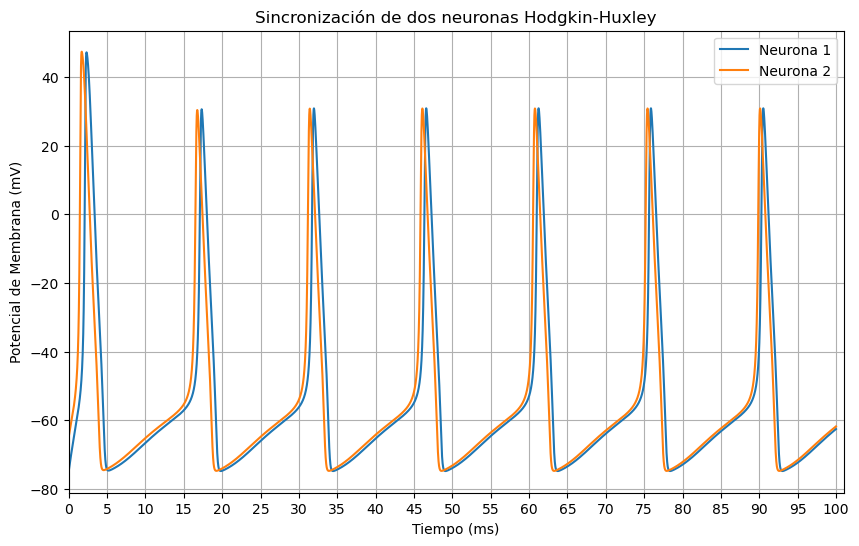

Tasa de disparo para la Neurona 1: 70.01 Hz
Tasa de disparo para la Neurona 2: 70.01 Hz


In [56]:
# De modelan dos neurons don V_syn=0 y tiempo de simulacion t_max de 1000s I_ext=10.0, g_syn= 0.1

# Create a system of two synchronized Hodgkin-Huxley neurons with synaptic interaction
hh_sync = HodgkinHuxleySync(I_ext=10.0, g_syn=0.1, V1_init=-75.0, V2_init=-65.0, t_max=100.0, dt=0.01,V_syn=0)

# hh_sync.simulate()
phase_shift, time_shift, avg_percentage_shift = hh_sync.estimate_phase_shift()
# print(f"Desfasaje Estimado: {phase_shift:.2f} radianes")
# print(f"Desfasaje en tiempo: {time_shift:.2f} ms")
# print(f"Desfasaje en porcentaje: {avg_percentage_shift:.2f} %")


# Simulate and plot the membrane potentials of both neurons over time
hh_sync.plot_membrane_potentials()

# Count the number of spikes (firing rate in Hz) for both neurons
firing_rate1, firing_rate2 = hh_sync.count_spikes(threshold=-10)
# print(f"Tasa de disparo para la Neurona 1: {firing_rate1:.2f} Hz")
# print(f"Tasa de disparo para la Neurona 2: {firing_rate2:.2f} Hz")


Desfasaje Estimado: -0.06 radianes
Desfasaje en tiempo: -0.14 ms
Desfasaje en porcentaje: -0.96 %


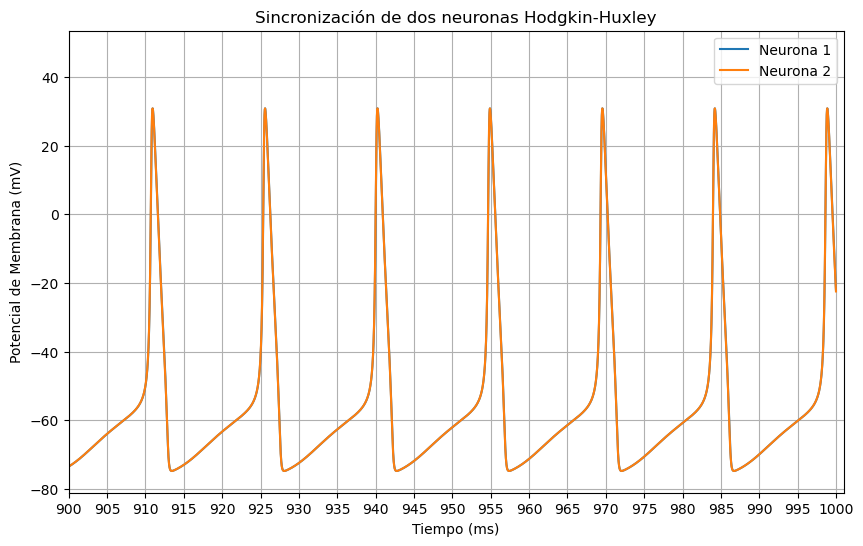

Tasa de disparo para la Neurona 1: 69.00 Hz
Tasa de disparo para la Neurona 2: 69.00 Hz


In [57]:
# De modelan dos neurons don V_syn=0 y tiempo de simulacion t_max de 1000s I_ext=10.0, g_syn= 0.1

# Create a system of two synchronized Hodgkin-Huxley neurons with synaptic interaction
hh_sync = HodgkinHuxleySync(I_ext=10.0, g_syn=0.1, V1_init=-75.0, V2_init=-65.0, t_max=1000.0, dt=0.01,V_syn=0)

# hh_sync.simulate()
phase_shift, time_shift, avg_percentage_shift = hh_sync.estimate_phase_shift()

# Simulate and plot the membrane potentials of both neurons over time
hh_sync.plot_membrane_potentials()

# Count the number of spikes (firing rate in Hz) for both neurons
firing_rate1, firing_rate2 = hh_sync.count_spikes(threshold=-10)


## Ejemplo 2 con $V_\text{syn}= -80mV$

### Primeros 100ms

Desfasaje Estimado: -0.54 radianes
Desfasaje en tiempo: -1.27 ms
Desfasaje en porcentaje: -8.65 %


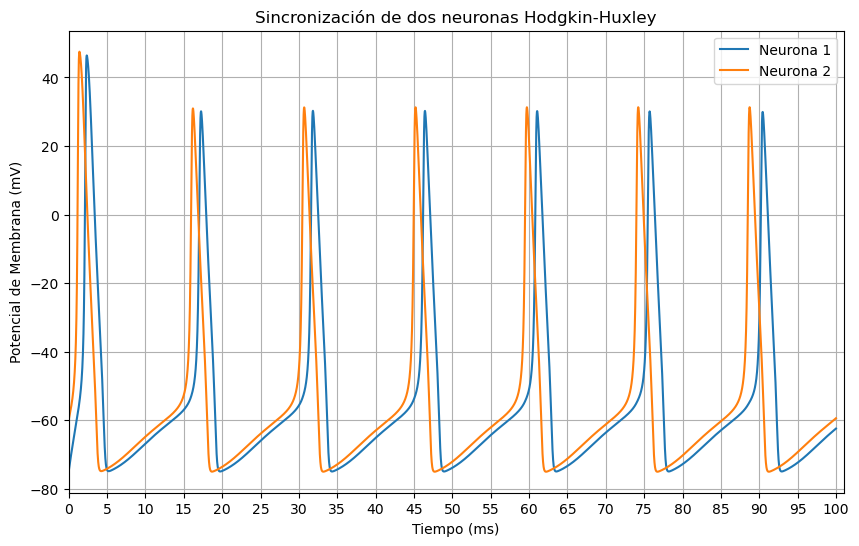

Tasa de disparo para la Neurona 1: 70.01 Hz
Tasa de disparo para la Neurona 2: 70.01 Hz


In [58]:
# Create a system of two synchronized Hodgkin-Huxley neurons with synaptic interaction
hh_sync = HodgkinHuxleySync(I_ext=10.0, g_syn=0.5, V1_init=-75.0, V2_init=-60.0, t_max=100.0, dt=0.01,V_syn=-80)

phase_shift, time_shift, avg_percentage_shift = hh_sync.estimate_phase_shift()

# Simulate and plot the membrane potentials of both neurons over time
hh_sync.plot_membrane_potentials()

# Count the number of spikes (firing rate in Hz) for both neurons
firing_rate1, firing_rate2 = hh_sync.count_spikes(threshold=-10)


Desfasaje Estimado: -9.29 radianes
Desfasaje en tiempo: -22.08 ms
Desfasaje en porcentaje: -147.88 %


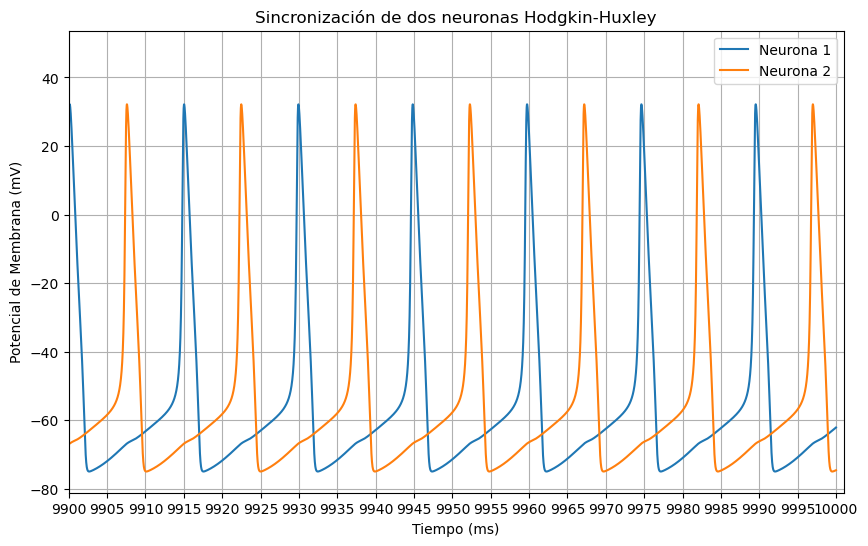

Tasa de disparo para la Neurona 1: 67.00 Hz
Tasa de disparo para la Neurona 2: 67.20 Hz


In [59]:
# Create a system of two synchronized Hodgkin-Huxley neurons with synaptic interaction
hh_sync = HodgkinHuxleySync(I_ext=10.0, g_syn=0.5, V1_init=-75.0, V2_init=-60.0, t_max=10000.0, dt=0.01,V_syn=-80)

phase_shift, time_shift, avg_percentage_shift = hh_sync.estimate_phase_shift()

# Simulate and plot the membrane potentials of both neurons over time
hh_sync.plot_membrane_potentials()

# Count the number of spikes (firing rate in Hz) for both neurons
firing_rate1, firing_rate2 = hh_sync.count_spikes(threshold=-10)


# Ejercicio 2

Para resolver el problema, comencemos analizando el sistema de ecuaciones diferenciales:

$$
\tau \frac{dh_e}{dt} = -h_e + g_{ee} f_e - g_{ei} f_i + I_e
$$

$$
\tau \frac{dh_i}{dt} = -h_i + g_{ie} f_e - g_{ii} f_i + I_i
$$

donde 
$$ f_a = S(h_a) $$ 
con $a = e, i$, y $S(x) = x H(x)$, siendo $H(x)$ la función de Heaviside.

### 1. Condición para Actividad Distinta de Cero
La actividad no nula ocurre cuando $h_e$ y/o $h_i$ son diferentes de cero. La función $S(x) = x H(x)$ es cero cuando $x \leq 0$ y es igual a $x$ cuando $x > 0$. Por lo tanto, $h_e > 0$ o $h_i > 0$ conduce a una actividad distinta de cero.

Para que haya actividad no nula:

$$ h_e > 0 \quad \text{y/o} \quad h_i > 0 $$

Esto implica que en equilibrio ($\frac{dh_e}{dt} = 0$ y $\frac{dh_i}{dt} = 0$), las condiciones se vuelven:

$$ h_e = g_{ee} f_e - g_{ei} f_i + I_e > 0 $$

$$ h_i = g_{ie} f_e - g_{ii} f_i + I_i > 0 $$

Estas condiciones deben satisfacerse para tener un punto de equilibrio distinto de cero.

### 2. Estabilidad de la Solución
Para analizar la estabilidad, consideremos pequeñas perturbaciones alrededor de los puntos de equilibrio $h_e^*$ y $h_i^*$. Linealizando el sistema alrededor del equilibrio, obtenemos la matriz Jacobiana $J$ del sistema:

$$
J = \begin{pmatrix}
- \frac{1}{\tau} + g_{ee} S'(h_e^*) & -g_{ei} S'(h_i^*) \\
g_{ie} S'(h_e^*) & -\frac{1}{\tau} - g_{ii} S'(h_i^*)
\end{pmatrix}
$$

La condición de estabilidad requiere que las partes reales de los valores propios de la matriz Jacobiana sean negativas. Los valores propios $\lambda$ satisfacen la ecuación característica:

$$ \lambda^2 + \text{tr}(J) \lambda + \text{det}(J) = 0 $$

donde 
$$ \text{tr}(J) = -\frac{2}{\tau} + (g_{ee} - g_{ii}) S'(h_e^*, h_i^*) $$ 
es el trazo, y 
$$ \text{det}(J) $$ 
es el determinante de la Jacobiana. Para que el sistema sea estable:

- El trazo $\text{tr}(J)$ debe ser negativo.
- El determinante $\text{det}(J)$ debe ser positivo.

Las expresiones para $S'(h_e^*)$ y $S'(h_i^*)$ dependen de la función de Heaviside. Si $h_a^* > 0$, entonces $S'(h_a^*) = 1$; si $h_a^* \leq 0$, entonces $S'(h_a^*) = 0$.

Por lo tanto, las condiciones sobre los parámetros de la red $g_{ee}, g_{ei}, g_{ie}, g_{ii}$ y las entradas $I_e, I_i$ determinan si el sistema puede tener actividad no nula y si esta actividad es estable.



## Simplificando para los valores positivos

Para valores $h_e^*>0$ y $h_i^*>0$ se cumple que $S'(h_e^*) = S'(h_i^*) = 1$, podemos simplificar las expresiones para la matriz Jacobiana $J$ y las condiciones para la estabilidad.

### 1. Matriz Jacobiana

La matriz Jacobiana $J$ se convierte en:

$$
J = \begin{pmatrix}
- \frac{1}{\tau} + g_{ee} & -g_{ei} \\
g_{ie} & -\frac{1}{\tau} - g_{ii}
\end{pmatrix}
$$

### 2. Ecuación Característica

La ecuación característica para los valores propios $\lambda$ es:

$$
\lambda^2 + \text{tr}(J) \lambda + \det(J) = 0
$$

Donde:

- La traza $\text{tr}(J)$ es la suma de los elementos diagonales:

$$
\text{tr}(J) = \left( - \frac{1}{\tau} + g_{ee} \right) + \left( - \frac{1}{\tau} - g_{ii} \right) = - \frac{2}{\tau} + g_{ee} - g_{ii}
$$

- El determinante $\det(J)$ es:

$$
\det(J) = \left( - \frac{1}{\tau} + g_{ee} \right) \left( - \frac{1}{\tau} - g_{ii} \right) - (- g_{ei})(g_{ie})
$$

Expandiendo esta expresión:

$$
\det(J) = \left( \frac{1}{\tau^2} - g_{ee}\frac{1}{\tau} - g_{ii}\frac{1}{\tau} + g_{ee}g_{ii} \right) + g_{ei}g_{ie}
$$

Por lo tanto:

$$
\det(J) = \frac{1}{\tau^2} - (g_{ee} + g_{ii})\frac{1}{\tau} + g_{ee}g_{ii} + g_{ei}g_{ie}
$$

### 3. Condiciones de Estabilidad

Para que el sistema sea estable:

1. **La traza $\text{tr}(J)$ debe ser negativa**:

$$
\text{tr}(J) = - \frac{2}{\tau} + g_{ee} - g_{ii} < 0
$$

Esto implica la condición:

$$
g_{ee} - g_{ii} < \frac{2}{\tau}
$$

2. **El determinante $\det(J)$ debe ser positivo**:

$$
\det(J) = \frac{1}{\tau^2} - (g_{ee} + g_{ii})\frac{1}{\tau} + g_{ee}g_{ii} + g_{ei}g_{ie} > 0
$$

Esta condición asegura que el sistema no tiene valores propios con partes reales positivas, lo que indicaría inestabilidad.

### Resumen de Condiciones de Estabilidad

Para que el sistema sea estable, las condiciones son:

1. $g_{ee} - g_{ii} < \frac{2}{\tau}$ (condición de la traza).
2. $\frac{1}{\tau^2} - (g_{ee} + g_{ii})\frac{1}{\tau} + g_{ee}g_{ii} + g_{ei}g_{ie} > 0$ (condición del determinante).

Estas condiciones deben cumplirse para que el sistema sea estable.
